In [ ]:



hv.extension('bokeh')
pn.extension()

# Widgets
window_length = pn.widgets.IntInput(name='Window Length', value=1024, step=1)
sample_rate = pn.widgets.IntInput(name='Original Sample Rate', value=4096, step=1)
decimation_factor = pn.widgets.IntInput(name='Decimation Factor', value=4, step=1)
num_decimations = pn.widgets.IntInput(name='Number of Decimations', value=4, step=1)
bands_per_level = pn.widgets.IntInput(name='Bands per Decimation Level', value=5, step=1)
band_width_freqs = pn.widgets.IntInput(name='Band Width (in # of frequencies)', value=5, step=1)
save_button = pn.widgets.Button(name='Save Frequency Bands', button_type='primary')

# Compute frequency arrays
def compute_frequencies(window_len, sample_rt, decim_fac, num_decim):
    freqs_by_level = []
    for level in range(num_decim):
        rate = sample_rt / (decim_fac ** level)
        freqs = np.fft.rfftfreq(window_len, d=1/rate)
        freqs_by_level.append((rate, freqs))
    return freqs_by_level

# def calculate_bands(freqs, rate, num_bands, band_width):
#     ...:     if len(freqs) == 0:
#     ...:         return []
#     ...:     f_min = max(freqs[1], 1e-6)
#     ...:     f_max = freqs[-1]
#     ...:     centers = np.logspace(np.log10(f_min), np.log10(f_max), num=num_bands)
#     ...:     bx = int(band_width/2)
#     ...:     bands = {}
#     ...:     for index, f in enumerate(centers, 1):
#     ...:         center_index = (freqs >= f).argmax()
#     ...:         left_index = max([0, int(center_index - bx)])
#     ...:         right_index = min([int(center_index + bx), freqs.size - 1])
#     ...:         bands[index] = {"index": (left_index, right_index), "values":(freqs[left_index], freqs[right_index])}
#     ...:
#     ...:     return bands

# Calculate log-spaced bands
def calculate_bands(freqs, rate, num_bands, band_width):
    if len(freqs) == 0:
        return []
    f_min = max(freqs[1], 1e-6)
    f_max = freqs[-1]
    centers = np.logspace(np.log10(f_min), np.log10(f_max), num=num_bands)
    bands = [(f - band_width/2 * (rate/window_length.value), f + band_width/2 * (rate/window_length.value)) for f in centers]
    return bands

# Plotting
@pn.depends(window_length, sample_rate, decimation_factor, num_decimations, bands_per_level, band_width_freqs)
def generate_plots(window_length, sample_rate, decimation_factor, num_decimations, bands_per_level, band_width_freqs):
    freqs_by_level = compute_frequencies(window_length, sample_rate, decimation_factor, num_decimations)
    plots = []
    for i, (rate, freqs) in enumerate(freqs_by_level):
        fmin, fmax = freqs[0], freqs[-1]
        curve = hv.Curve((freqs, np.ones_like(freqs)), label=f'Decimation Level {i}')
        curve = curve.opts(opts.Curve(height=200, width=600, tools=['hover', 'xwheel_zoom', 'box_zoom', 'reset'], title=f'Decimation Level {i}', xlabel='Frequency (Hz)', ylabel='Amplitude', xlim=(fmin, fmax), ylim=(0, 1.1), shared_axes=False))

        bands = calculate_bands(freqs, rate, bands_per_level, band_width_freqs)
        overlays = [curve]
        for band in bands:
            band_area = hv.Area(([band[0], band[1]], [1, 1])).opts(fill_alpha=0.3, fill_color='orange')
            overlays.append(band_area)

        plots.append(hv.Overlay(overlays).opts(shared_axes=False))
    return hv.Layout(plots).cols(1)

# Save bands
def save_bands(event):
    freqs_by_level = compute_frequencies(window_length.value, sample_rate.value, decimation_factor.value, num_decimations.value)
    bands_dict = {}
    for i, (rate, freqs) in enumerate(freqs_by_level):
        bands = calculate_bands(freqs, rate, bands_per_level.value, band_width_freqs.value)
        bands_dict[f'Decimation_Level_{i}'] = [{'min_freq': round(b[0], 2), 'max_freq': round(b[1], 2)} for b in bands]
    with open('selected_frequency_bands.json', 'w') as f:
        json.dump(bands_dict, f, indent=4)
    print("Frequency bands saved to selected_frequency_bands.json")

save_button.on_click(save_bands)

# Layout
controls = pn.Column(window_length, sample_rate, decimation_factor, num_decimations, bands_per_level, band_width_freqs, save_button)
app = pn.Row(controls, generate_plots)

# Serve
app.servable()


In [1]:
import numpy as np

In [2]:
def compute_frequencies(window_len, sample_rt, decim_fac, num_decim):
    freqs_by_level = []
    for level in range(num_decim):
        rate = sample_rt / (decim_fac ** level)
        freqs = np.fft.rfftfreq(window_len, d=1/rate)
        freqs_by_level.append((rate, freqs))
    return freqs_by_level

In [4]:
def calculate_bands(freqs, rate, num_bands, band_width):
     if len(freqs) == 0:
         return []
     f_min = max(freqs[1], 1e-6)
     f_max = freqs[-1]
     centers = np.logspace(np.log10(f_min*1.1), np.log10(f_max*0.9), num=num_bands)
     
     bands = {}
     for index, f in enumerate(centers, 1):
         bx = int((band_width/2)*(index/2))
         center_index = (freqs >= f).argmax()
         left_index = max([0, int(center_index - bx)])
         right_index = min([int(center_index + bx), freqs.size - 1])
         bands[index] = {"index": (left_index, right_index), "values":(freqs[left_index], freqs[right_index])}

     return bands

In [10]:
frequencies = compute_frequencies(1024, 4096, 4, 3)

0 431 491: 1724.0 Hz to 1964.0 Hz
0 327 383: 1308.0 Hz to 1532.0 Hz
0 246 300: 984.0 Hz to 1200.0 Hz
0 184 236: 736.0 Hz to 944.0 Hz
0 137 187: 548.0 Hz to 748.0 Hz
0 102 148: 408.0 Hz to 592.0 Hz
0 74 118: 296.0 Hz to 472.0 Hz
0 53 95: 212.0 Hz to 380.0 Hz
0 37 77: 148.0 Hz to 308.0 Hz
0 26 62: 104.0 Hz to 248.0 Hz
0 17 51: 68.0 Hz to 204.0 Hz
0 10 42: 40.0 Hz to 168.0 Hz
0 5 35: 20.0 Hz to 140.0 Hz
0 3 29: 12.0 Hz to 116.0 Hz
0 0 24: 0.0 Hz to 96.0 Hz
0 0 20: 0.0 Hz to 80.0 Hz
0 0 17: 0.0 Hz to 68.0 Hz
0 0 14: 0.0 Hz to 56.0 Hz
0 0 12: 0.0 Hz to 48.0 Hz
0 0 10: 0.0 Hz to 40.0 Hz
0 0 8: 0.0 Hz to 32.0 Hz
0 0 5: 0.0 Hz to 20.0 Hz
0 0 4: 0.0 Hz to 16.0 Hz
0 1 3: 4.0 Hz to 12.0 Hz
1 431 491: 431.0 Hz to 491.0 Hz
1 327 383: 327.0 Hz to 383.0 Hz
1 246 300: 246.0 Hz to 300.0 Hz
1 184 236: 184.0 Hz to 236.0 Hz
1 137 187: 137.0 Hz to 187.0 Hz
1 102 148: 102.0 Hz to 148.0 Hz
1 74 118: 74.0 Hz to 118.0 Hz
1 53 95: 53.0 Hz to 95.0 Hz
1 37 77: 37.0 Hz to 77.0 Hz
1 26 62: 26.0 Hz to 62.0 Hz
1 17 5

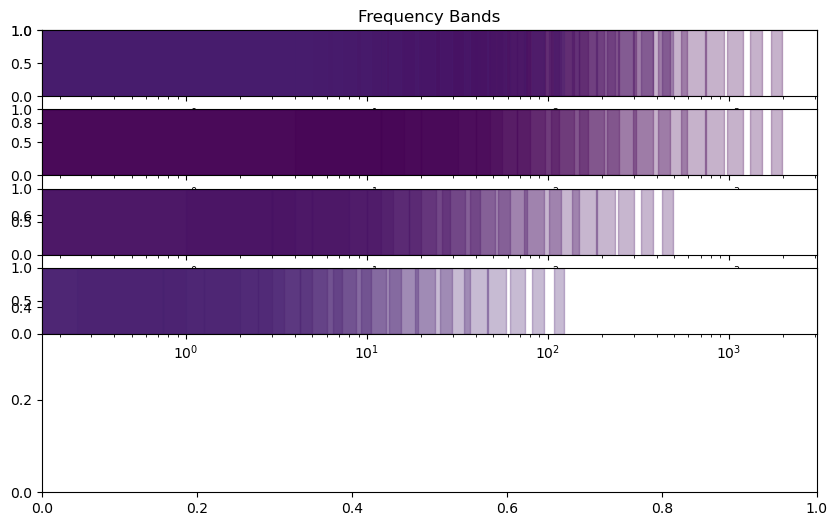

In [12]:
from matplotlib import pyplot as plt

fig = plt.figure(2, figsize=(10, 6))
plt.title("Frequency Bands")
ax = fig.add_subplot(6, 1, 1)


for ii, b in enumerate([calculate_bands(ff[1], 4096/(4**ii), 24, 5) for ii, ff in enumerate(frequencies, 0)]):
    ax2 = fig.add_subplot(6, 1, 2 + ii, sharex=ax)
    
    lines = []
    for k, v in b.items():
        ax.axvspan(v['values'][0], v['values'][1], alpha=0.3, color=plt.cm.viridis(ii / len(b)))
        ax2.axvspan(v['values'][0], v['values'][1], alpha=0.3, color=plt.cm.viridis(ii / len(b)))
        
        # ax.plot([v['values'][0], v['values'][1]], [0, 1], label=f"Band {ii}", color=plt.cm.viridis(ii / len(b)), linewidth=2)
        lines.append(f"{ii} {v['index'][0]} {v['index'][1]}: {v['values'][0]} Hz to {v['values'][1]} Hz")
    print("\n".join(lines[::-1]))
    ax2.set_xscale("log")
ax.set_xscale('log')
ax.set_xlabel("Frequency (Hz)")
plt.show()